Jako model sieciu użyto modelu z artykułu https://arxiv.org/abs/2009.11212

Wyjaśnienie batch_size https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network

In [1]:
!pwd
!ls
!ls ../../../SpinakerV1Data/2023-05-19

/tf/SpinakerV1/assets/jupyter
__pycache__  model1.ipynb
data.csv  img


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.python.keras.models import load_model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import cv2
import pandas as pd
import ntpath
import random
import tensorflow as tf

tf.random.set_seed(42)
print(keras.__version__)
print(tf.__version__)

%matplotlib inline

2.11.0
2.11.0


In [3]:
datadir = '../../../SpinakerV1Data/2023-05-19'
data = pd.read_csv(os.path.join(datadir, 'data.csv'))
pd.set_option('display.max_colwidth', None)
data.head()
print(data)

          filename    v     omega
0      img/000.jpg  0.4  0.716167
1      img/001.jpg  0.4  0.941750
2      img/002.jpg  0.4  1.193167
3      img/003.jpg  0.4  1.470500
4      img/004.jpg  0.4  1.723667
...            ...  ...       ...
1757  img/1757.jpg  0.4 -0.321083
1758  img/1758.jpg  0.4 -0.244250
1759  img/1759.jpg  0.4 -0.117000
1760  img/1760.jpg  0.4 -0.039500
1761  img/1761.jpg  0.4  0.038250

[1762 rows x 3 columns]


[-5.75433302 -5.53074636 -5.30715969 -5.08357303 -4.85998636 -4.6363997
 -4.41281303 -4.18922637 -3.96563971 -3.74205304 -3.51846638 -3.29487971
 -3.07129305 -2.84770638 -2.62411972 -2.40053306 -2.17694639 -1.95335973
 -1.72977306 -1.5061864  -1.28259974 -1.05901307 -0.83542641 -0.61183974
 -0.38825308 -0.16466641  0.05892025  0.28250691  0.50609358  0.72968024
  0.95326691  1.17685357  1.40044024  1.6240269   1.84761356  2.07120023
  2.29478689  2.51837356  2.74196022  2.96554688  3.18913355  3.41272021
  3.63630688  3.85989354  4.08348021  4.30706687  4.53065353  4.7542402
  4.97782686  5.20141353  5.42500019]
[-5.64253969 -5.41895302 -5.19536636 -4.97177969 -4.74819303 -4.52460637
 -4.3010197  -4.07743304 -3.85384637 -3.63025971 -3.40667305 -3.18308638
 -2.95949972 -2.73591305 -2.51232639 -2.28873972 -2.06515306 -1.8415664
 -1.61797973 -1.39439307 -1.1708064  -0.94721974 -0.72363307 -0.50004641
 -0.27645975 -0.05287308  0.17071358  0.39430025  0.61788691  0.84147357
  1.06506024  1.

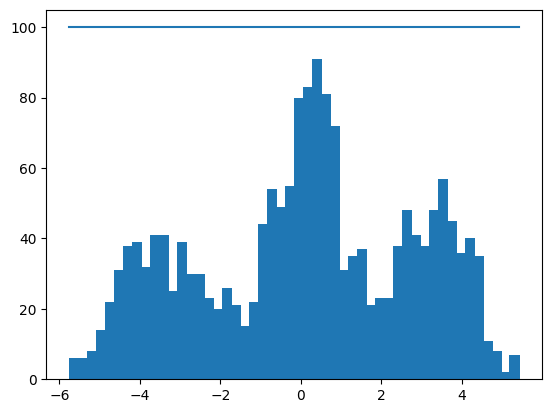

In [4]:
num_bins = 50
samples_per_bin = 100
hist, bins = np.histogram(data['omega'], num_bins)
center = (bins[:-1]+bins[1:]) * 0.5
plt.bar(center, hist, width=0.25)
plt.plot((np.min(data['omega']), np.max(data['omega'])), (samples_per_bin, samples_per_bin))
print(bins)
print(center)

total date: 1762
removed  0
remaning 1762


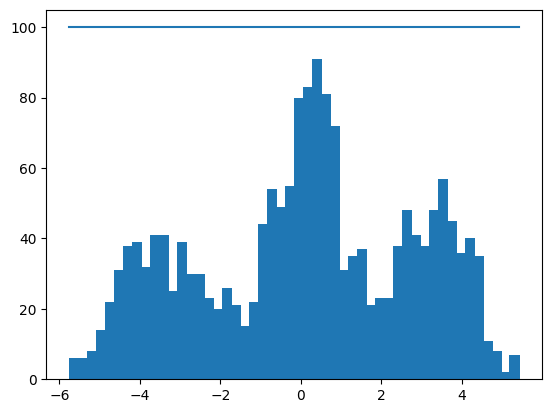

In [5]:
print('total date:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['omega'])):
    if data['omega'][i] >= bins[j] and data['omega'][i] <= bins[j+1]:
      list_.append(i) 
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed ', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaning', len(data))

hist, _ = np.histogram(data['omega'], num_bins)
plt.bar(center, hist, width=0.25)
plt.plot((np.min(data['omega']), np.max(data['omega'])), (samples_per_bin, samples_per_bin))

In [8]:
print(data.iloc[1])
def load_img_stearing(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        # Save path to image
        image_path.append(os.path.join(datadir, data.iloc[i].filename.strip()))
        # Save omega 
        steering.append(float( data.iloc[i].omega ))

    image_paths = np.array(image_path)
    steerings = np.array(steering)
    return image_paths, steerings                                           

image_paths, steerings = load_img_stearing(datadir, data)

filename    img/001.jpg
v                   0.4
omega           0.94175
Name: 1, dtype: object


In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Traning Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))
print(X_train[1])
print(y_train[1])

Traning Samples: 1409
Valid Samples: 353
../../../SpinakerV1Data/2023-05-19/img/091.jpg
-0.9610000252723694


/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:1241: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '0.9764705882352941 0.023529411764705882')

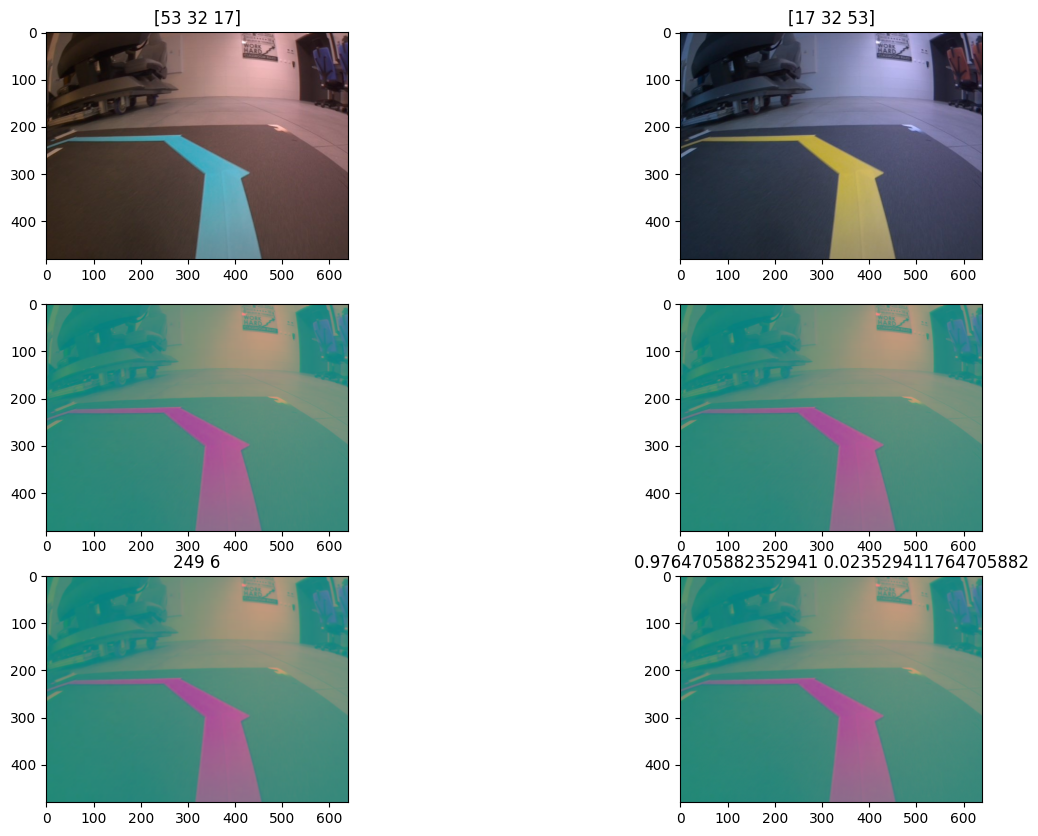

In [10]:
fig, axes = plt.subplots(3, 2, figsize=(15,10))
imgo = cv2.imread(image_paths[100], cv2.IMREAD_COLOR)
axes[0,0].set_title(imgo[0,0,:])
axes[0,0].imshow(imgo)
axes[0,0].axis('on')

imgc = cv2.cvtColor(imgo, cv2.COLOR_BGR2RGB)
axes[0,1].set_title(imgc[0,0,:])
axes[0,1].imshow(imgc)
axes[0,1].axis('on')

axes[1,0].imshow(cv2.cvtColor( imgo, cv2.COLOR_BGR2YUV))
axes[1,1].imshow(cv2.cvtColor( imgc, cv2.COLOR_RGB2YUV))

imagecg = cv2.GaussianBlur(cv2.cvtColor( imgo, cv2.COLOR_BGR2YUV), (3, 3), 0)
axes[2,0].imshow( imagecg )
axes[2,0].set_title("{} {}".format(np.max(imagecg), np.min(imagecg)))
imgecg_n = (imagecg - np.min(imagecg)) / (np.max(imagecg) - np.min(imagecg))
imgecg_n = imagecg/255.0
axes[2,1].imshow( imgecg_n )
axes[2,1].set_title("{} {}".format(np.max(imgecg_n), np.min(imgecg_n)))


Text(0.5, 1.0, 'Validations sets')

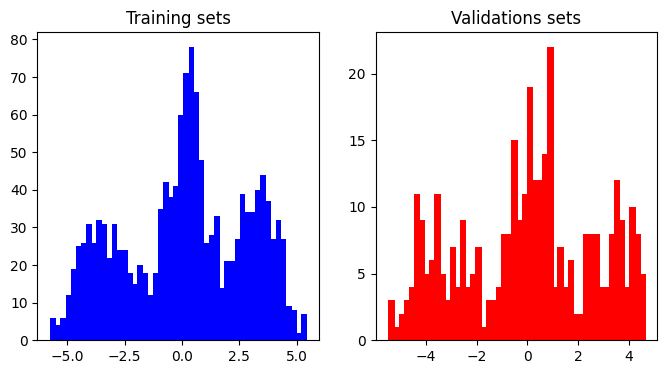

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].hist(y_train, bins=num_bins, width=0.25, color='blue')
axes[0].set_title('Training sets')
axes[1].hist(y_valid, bins=num_bins, width=0.25, color='red')
axes[1].set_title('Validations sets')

In [12]:
def img_preprocess(img_path):
    img = cv2.imread(img_path)
    img = img[300:500, :, :]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (80, 60))
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    return img

(-0.5, 79.5, 59.5, -0.5)

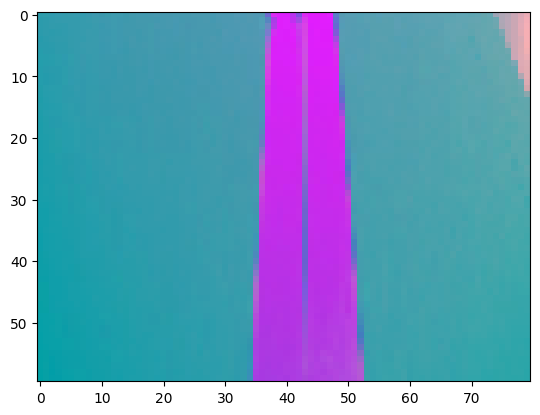

In [14]:
plt.imshow(img_preprocess(image_paths[random.randint(0, len(X_train)-1)]))
plt.axis('on')

Convert X_train with image paths to image as np.array

In [15]:
X_train = np.array(list(map(img_preprocess, X_train)))
X_valid = np.array(list(map(img_preprocess, X_valid)))

(1409, 60, 80, 3)


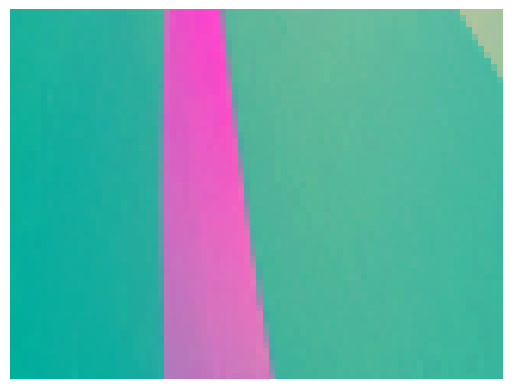

In [17]:
plt.imshow(X_train[random.randint(0, len(X_train)-1)] )
plt.axis('off')
print(X_train.shape)

In [18]:
def nvidia_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3,3), input_shape=(60,80,3),activation='relu'))
    model.add(MaxPool2D((2,2)))
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
    model.add(MaxPool2D((2,2)))
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
    model.add(MaxPool2D((2,2)))

    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1))

    optimizer= Adam(learning_rate=1e-3)
    model.compile(loss='mse', optimizer=optimizer)

    return model

model=nvidia_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 58, 78, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 39, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 37, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 18, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 16, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 8, 64)         0

In [19]:
tf.random.set_seed(42)
model=nvidia_model()
history = model.fit(X_train, y_train, 
    epochs=10, 
    validation_data=(X_valid, y_valid), 
    batch_size=75, 
    verbose=1, shuffle=1)

Epoch 1/10
19/19 [==============================] - 3s 18ms/step - loss: 2.7411 - val_loss: 0.5229
Epoch 2/10
19/19 [==============================] - 0s 6ms/step - loss: 0.7246 - val_loss: 0.3658
Epoch 3/10
19/19 [==============================] - 0s 6ms/step - loss: 0.5330 - val_loss: 0.2896
Epoch 4/10
19/19 [==============================] - 0s 6ms/step - loss: 0.4803 - val_loss: 0.2421
Epoch 5/10
19/19 [==============================] - 0s 6ms/step - loss: 0.4285 - val_loss: 0.2553
Epoch 6/10
19/19 [==============================] - 0s 6ms/step - loss: 0.4155 - val_loss: 0.2349
Epoch 7/10
19/19 [==============================] - 0s 6ms/step - loss: 0.3907 - val_loss: 0.2342
Epoch 8/10
19/19 [==============================] - 0s 6ms/step - loss: 0.3406 - val_loss: 0.1902
Epoch 9/10
19/19 [==============================] - 0s 6ms/step - loss: 0.3363 - val_loss: 0.2272
Epoch 10/10
19/19 [==============================] - 0s 6ms/step - loss: 0.3444 - val_loss: 0.2536


Text(0.5, 0, 'Epoch')

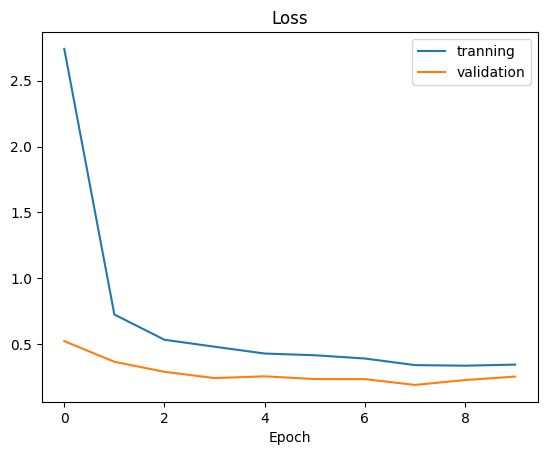

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['tranning', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

* model-2022-01-25-01.h5 - z normalizacja
* model-2022-01-25-02.h5 - bez normalizacji 

In [21]:
nn_model_path = '../../../SpinakerV1/assets/nn_models/'
nn_model_name = 'model-2023-05-19.h5'
model.save(nn_model_path + nn_model_name)

# Walidacja modelu

In [22]:
model2 = load_model(nn_model_path + nn_model_name)
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 58, 78, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 29, 39, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 27, 37, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 18, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 8, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 8, 64)         

img_index: 72, ../../../SpinakerV1Data/2023-05-19/img/072.jpg => steering: 1.274999976158142
NN model result steering: 0.7325924634933472
Difference between data and model prediction: 0.5424075126647949


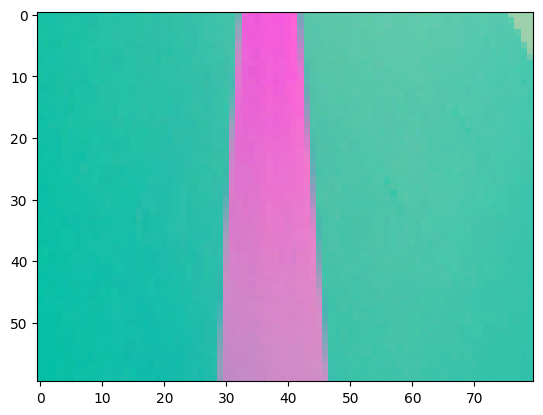

In [24]:
img_index = random.randint(0, len(X_train)-1)
prepared_image = np.array(img_preprocess(image_paths[img_index]))
plt.imshow(cv2.imread(image_paths[img_index], cv2.IMREAD_COLOR))
plt.imshow(prepared_image, aspect="auto")
model2_result = model2.predict_on_batch( np.expand_dims(prepared_image, 0))

print("img_index: {}, {} => steering: {}".format(img_index, image_paths[img_index], steerings[img_index]) )
print("NN model result steering: {}".format(model2_result[0,0]))
print("Difference between data and model prediction: {}".format(steerings[img_index]-model2_result[0,0]))